# Kaggle Titanic - Demo

## Feature Engineering

In [20]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer

def replace_titles(x):
        title=x['Title_']
        if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Master']:
            return 'Master'
        elif title in ['Countess', 'Mme','Mrs']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms','Miss']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        elif title =='':
            if x['Sex']=='Male':
                return 'Master'
            else:
                return 'Miss'
        else:
            return title

def feature_engineering(_df, get_dummies=False):

    imputer_age = Imputer(missing_values='NaN', strategy='mean', axis=0)

    imputer_age.fit(_df[['Age']])

    # Title:
    _df['Title_'] = _df['Name'].apply(lambda x: x.replace('.',',').split(',')[1].strip())
    _df['Title_'] = _df.apply(replace_titles, axis=1)

    # Fare:
    # fill NaN
    _df['Fare_'] = _df['Fare']
    _df.loc[ (_df.Fare.isnull())&(_df.Pclass==1),'Fare_'] =np.median(_df[_df['Pclass'] == 1]['Fare'].dropna())
    _df.loc[ (_df.Fare.isnull())&(_df.Pclass==2),'Fare_'] =np.median( _df[_df['Pclass'] == 2]['Fare'].dropna())
    _df.loc[ (_df.Fare.isnull())&(_df.Pclass==3),'Fare_'] = np.median(_df[_df['Pclass'] == 3]['Fare'].dropna())
    #
    _df['Fare_'] = _df['Fare_'] / (1+_df['SibSp']+_df['Parch'])
    _df['Fare_'] = _df['Fare_'].apply(lambda x: 40 if x > 40 else x)
    
    # SibSp and Parch:
    _df['SibSp_'] = _df['SibSp'].apply(lambda x: 3 if x > 3 else x)
    _df['Parch_'] = _df['Parch'].apply(lambda x: 3 if x > 3 else x)
    _df['FamilySize_'] = _df['SibSp_'] + _df['Parch_'];

    # Age
    _df['HasAge'] = _df['Age'].apply(lambda x: 0 if np.isnan(x) else 1)
    _df['Age_'] = imputer_age.transform(_df['Age'].reshape(-1, 1))
    # or
    #_df['Age_'] = _df["Age"].fillna(_df["Age"].mean())
    # http://stackoverflow.com/questions/21050426/pandas-impute-nans

    _df['Age_b'] = np.digitize(_df['Age_'], [0,5,10,15,20,25,28,30,35,40,45,50,55,60,65,70])

    # Cabin:
    _df['Cabin_'] = _df['Cabin'].apply(lambda x: 'X' if isinstance(x, float) else x[0])
    # NaN is no problem for get_dummies
    # However let's try to keep it as a feature called X

    # Embarked:
    _df['Embarked_'] = _df['Embarked'].apply(lambda x: 'S' if isinstance(x, float) else x)

    df_return = _df[['Age_','Age_b','HasAge','Sex','Pclass',
                     'Fare_','Title_','SibSp_', 'Parch_', 
                     'FamilySize_','Embarked_','Cabin_']]

    if get_dummies:
        return pd.get_dummies(df_return) # Onehot encoding
    else:
        return df_return


In [29]:
import pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math


df=pd.read_csv('data/train.csv', sep=',')
df_test=pd.read_csv('data/test.csv', sep=',')

df_d = feature_engineering(df, get_dummies=True)
df_d_test = feature_engineering(df_test, get_dummies=True)

features=[
          'Age_b', 'HasAge', 'Sex_female', 'Sex_male', 'Pclass', 'Fare_',
          'Title__Mr', 'Title__Master','Title__Mrs','Title__Miss', 'FamilySize_',
          'Embarked__C', 'Embarked__Q', 'Embarked__S'
         ]

df_d = df_d[features]
df_d_test = df_d_test[features]


In [30]:
df_d.head()

,Age_b,HasAge,Sex_female,Sex_male,Pclass,Fare_,Title__Mr,Title__Master,Title__Mrs,Title__Miss,FamilySize_,Embarked__C,Embarked__Q,Embarked__S
0,5,1,0,1,3,3.62500,1,0,0,0,1,0,0,1
1,9,1,1,0,1,35.64165,0,0,1,0,1,1,0,0
2,6,1,1,0,3,7.92500,0,0,0,1,0,0,0,1
3,9,1,1,0,1,26.55000,0,0,1,0,1,0,0,1
4,9,1,0,1,3,8.05000,1,0,0,0,0,0,0,1


## Train Test Data Split

In [33]:
from sklearn.cross_validation import train_test_split

X, y = df_d.iloc[:].values, df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

## Train a model only on the Train Data

In [34]:
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### GridSearchCV 

* Note, it might take a long time to solve with grid search. Try reduce the parameter ranges for searching if you wish to finish running it faster

In [65]:
from sklearn.grid_search import GridSearchCV

pipe = Pipeline([
        #('scaler', StandardScaler()),
        #('pca', KernelPCA(kernel='rbf')),
        #('clf', LogisticRegression(random_state=1))
        #('clf', KNeighborsClassifier())
        ('clf', RandomForestClassifier(n_estimators=1000,
                                       criterion='entropy',
                                       random_state=1,
                                       #min_samples_split=1, 
                                       #min_samples_leaf=1,
                                       max_features='auto',
                                       bootstrap=False,
                                       oob_score=False,
                                       #max_depth=4,
                                       #max_features=4,
                                       n_jobs=-1))
    ])


bootstrap_range = [True]
clf_max_depth_range = range(9, 12)
min_samples_leaf_range = range(1, 2)
min_samples_split_range = range(9, 12)


param_grid = [
    {
        'clf__bootstrap': bootstrap_range,
        'clf__max_depth': clf_max_depth_range,
        'clf__min_samples_leaf': min_samples_leaf_range,
        'clf__min_samples_split' : min_samples_split_range 
    }
]

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring='f1',
                  cv=10,
                  #verbose=3,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print gs.best_score_

print gs.best_params_

0.752087498999
{'clf__bootstrap': True, 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}


## Evaluate the model scores:

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

gs.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [67]:
print( 'Training Acc: %.3f' % accuracy_score(gs.predict(X_train), y_train))
print( 'Training Precision: %.3f' % precision_score(gs.predict(X_train), y_train))
print( 'Training Recall: %.3f' % recall_score(gs.predict(X_train), y_train))
print( 'Training F1: %.3f' % f1_score(gs.predict(X_train), y_train))

Training Acc: 0.890
Training Precision: 0.793
Training Recall: 0.907
Training F1: 0.846


In [68]:
print( 'Test Acc: %.3f' % accuracy_score(gs.predict(X_test), y_test))
print( 'Test Precision: %.3f' % precision_score(gs.predict(X_test), y_test))
print( 'Test Recall: %.3f' % recall_score(gs.predict(X_test), y_test))
print( 'Test F1: %.3f' % f1_score(gs.predict(X_test), y_test))

Test Acc: 0.866
Test Precision: 0.750
Test Recall: 0.900
Test F1: 0.818


In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_test, gs.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          0       0.85      0.94      0.89       107
          1       0.90      0.75      0.82        72

avg / total       0.87      0.87      0.86       179



## Nested CrossValidation to give a better score evaluation on the model

In [72]:
scores = cross_validation.cross_val_score(gs.best_estimator_, X, y, scoring='accuracy', cv=10, n_jobs=-1)
print('Cross validation check for Acc: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross validation check for Acc: 0.834 +/- 0.044


In [73]:
scores = cross_validation.cross_val_score(gs.best_estimator_, X, y, scoring='f1', cv=10, n_jobs=-1)
print('Cross validation check for F1: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross validation check for F1: 0.766 +/- 0.073


## Train a model with all training data and do prediction on Kaggle test data

In [74]:
clf = gs.best_estimator_
clf.fit(X, y)

Pipeline(steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

(array([ 268.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  150.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

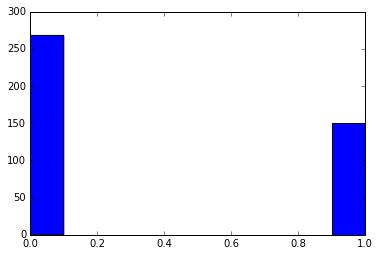

In [75]:
df_test['Survived'] = clf.predict(df_d_test)
plt.hist(df_test['Survived'] )

## Save result in file for Kaggle

In [76]:
import csv as csv
predictions_file = open("Demo1.csv", "wb")
predictions_file_object = csv.writer(predictions_file)
predictions_file_object.writerow(["PassengerId", "Survived"]) # write the column headers
for index, row in df_test.iterrows():  # For each row in test file
    predictions_file_object.writerow([row['PassengerId'], row['Survived']]) # write the PassengerId, and predict 1
predictions_file.close()

## Result

By submitting the result csv to Kaggle, we get a score on Leaderboard of 0.76555